# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_058  Q06033;Q06033-2   19.047
Sample_205  P16519;P16519-3   16.001
Sample_001  O14498            20.050
Sample_007  Q15293            15.039
Sample_101  P0C6S8            14.153
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                   
Sample_108  Q8N608;Q8N608-2;Q8N608-3;Q8N608-4   15.301
Sample_034  E9PHY0;E9PP23;E9PQY3;P11117         14.056
Sample_099  O75339                              10.433
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.003
            A0A075B6Q5                 12.278
            A0A075B6R2                 12.370
            A0A075B6S5                 12.921
            A0A087WSY4                 13.675
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.443
            Q9UI40;Q9UI40-2            12.253
            Q9UIW2                     12.147
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.378
            Q9UP79                     12.432
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.385,15.050,16.842,19.863,13.367,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.733,19.067,...,15.528,15.576,11.803,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.676,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,12.763,17.705,17.039,14.420,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.088,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.274,15.345,17.084,18.708,14.249,19.433,9.633,8.915
Sample_207,15.739,16.877,15.469,16.898,10.991,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.003,...,16.012,15.178,12.912,15.050,16.842,19.863,12.612,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.415,19.067,16.188,...,15.528,15.576,11.294,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.027,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.445,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.275,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.451,15.345,17.084,18.708,14.249,19.433,13.010,11.974
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 389.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.88it/s]

100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.79it/s]

100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:01,  2.85it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.93it/s]

 80%|████████  | 4/5 [00:02<00:00,  1.77it/s]

100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.37it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.27it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.24it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.42it/s]

100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.74it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.69it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.67it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.62it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.70it/s]

100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.71it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.90it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.18it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.97it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.74it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.78it/s]

100%|██████████| 8/8 [00:02<00:00,  2.47it/s]

100%|██████████| 8/8 [00:02<00:00,  2.85it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.52it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.66it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.58it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.38it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.31it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.05it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.99it/s]

100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

100%|██████████| 9/9 [00:04<00:00,  2.16it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.39it/s]

 30%|███       | 3/10 [00:00<00:02,  3.41it/s]

 40%|████      | 4/10 [00:01<00:02,  2.85it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.43it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.85it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.72it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.84it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.94it/s]

100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.70it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.28it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.09it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.03it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.92it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.08it/s]

 82%|████████▏ | 9/11 [00:04<00:00,  2.20it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.37it/s]

100%|██████████| 11/11 [00:04<00:00,  2.51it/s]

100%|██████████| 11/11 [00:04<00:00,  2.28it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  3.02it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.29it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.14it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.04it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.06it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.07it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.15it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.32it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.48it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.67it/s]

100%|██████████| 12/12 [00:05<00:00,  2.71it/s]

100%|██████████| 12/12 [00:05<00:00,  2.38it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.96it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.90it/s]

 31%|███       | 4/13 [00:01<00:03,  2.61it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.50it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.32it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.22it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.18it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.30it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.46it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.61it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.77it/s]

100%|██████████| 13/13 [00:04<00:00,  2.89it/s]

100%|██████████| 13/13 [00:05<00:00,  2.60it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.31it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.16it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.62it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.29it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.29it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.25it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.36it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.44it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.59it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.64it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.74it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.89it/s]

100%|██████████| 14/14 [00:05<00:00,  2.96it/s]

100%|██████████| 14/14 [00:05<00:00,  2.69it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.67it/s]

 20%|██        | 3/15 [00:00<00:03,  3.01it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.45it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.51it/s]

 40%|████      | 6/15 [00:02<00:03,  2.52it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.50it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.50it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.45it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.49it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.53it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.71it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.86it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.88it/s]

100%|██████████| 15/15 [00:05<00:00,  2.92it/s]

100%|██████████| 15/15 [00:05<00:00,  2.71it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.051 0.014          0.754 0.355       0.113   
2             0.004 0.002      0.050 0.009          0.702 0.096       0.599   
3             0.003 0.000      0.043 0.006          0.698 0.113       0.592   
4             0.004 0.003      0.051 0.018          0.673 0.092       0.641   
5             0.004 0.002      0.054 0.015          0.690 0.099       0.677   
6             0.006 0.005      0.071 0.029          0.789 0.091       0.789   
7             0.007 0.005      0.073 0.024          0.794 0.087       0.796   
8             0.005 0.003      0.060 0.018          0.796 0.087       0.802   
9             0.005 0.003      0.061 0.021          0.791 0.074       0.831   
10            0.004 0.001      0.062 0.026          0.791 0.075       0.833   
11            0.005 0.004      0.072 0.038          0.795 0.078       0.823   
12            0.007 0.006      0.072 0.036          0.804 0.079       0.816   
13            0.007 0.011      0.081 0.050          0.802 0.084       0.820   
14            0.008 0.008      0.090 0.044          0.797 0.085       0.811   
15            0.007 0.005      0.096 0.042          0.794 0.083       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.189 0.126                  0.549 0.039        0.845   
2          0.102   0.641 0.082                  0.704 0.062        0.777   
3          0.113   0.633 0.088                  0.698 0.066        0.780   
4          0.112   0.649 0.079                  0.704 0.062        0.779   
5          0.116   0.677 0.081                  0.724 0.066        0.792   
6          0.117   0.783 0.081                  0.815 0.068        0.888   
7          0.111   0.790 0.076                  0.821 0.065        0.887   
8          0.105   0.794 0.074                  0.824 0.063        0.891   
9          0.096   0.807 0.063                  0.834 0.056        0.908   
10         0.095   0.808 0.063                  0.835 0.056        0.907   
11         0.100   0.805 0.067                  0.833 0.059        0.905   
12         0.101   0.806 0.067                  0.834 0.057        0.913   
13         0.100   0.807 0.070                  0.835 0.060        0.911   
14         0.098   0.799 0.067                  0.828 0.057        0.909   
15         0.098   0.796 0.068                  0.825 0.058        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.813 0.095        210.000 0.000  
2          0.073                  0.753 0.089        210.000 0.000  
3          0.072                  0.728 0.099        210.000 0.000  
4          0.071                  0.728 0.096        210.000 0.000  
5          0.068                  0.754 0.098        210.000 0.000  
6          0.054                  0.850 0.071        210.000 0.000  
7          0.053                  0.849 0.070        210.000 0.000  
8          0.053                  0.863 0.065        210.000 0.000  
9          0.049                  0.896 0.048        210.000 0.000  
10         0.049                  0.896 0.050        210.000 0.000  
11         0.050                  0.893 0.051        210.000 0.000  
12         0.050                  0.905 0.048        210.000 0.000  
13         0.051                  0.902 0.049        210.000 0.000  
14         0.051                  0.900 0.049        210.000 0.000  
15         0.052                  0.898 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 462.39it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.68it/s]

100%|██████████| 3/3 [00:00<00:00,  3.82it/s]

100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.34it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.55it/s]

100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.42it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.81it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.39it/s]

100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.50it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.94it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.48it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.31it/s]

100%|██████████| 6/6 [00:01<00:00,  3.16it/s]

100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.75it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.70it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.85it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.52it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.24it/s]

100%|██████████| 7/7 [00:02<00:00,  2.14it/s]

100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.39it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.34it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.95it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.81it/s]

100%|██████████| 8/8 [00:04<00:00,  1.72it/s]

100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.64it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.79it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.10it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.64it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.28it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.10it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.03it/s]

100%|██████████| 9/9 [00:03<00:00,  1.95it/s]

100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.03it/s]

 30%|███       | 3/10 [00:00<00:02,  3.35it/s]

 40%|████      | 4/10 [00:01<00:01,  3.09it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.61it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.26it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.08it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.01it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.94it/s]

100%|██████████| 10/10 [00:04<00:00,  1.82it/s]

100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.55it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.02it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.48it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.26it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.52it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.12it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.93it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.82it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.68it/s]

100%|██████████| 11/11 [00:05<00:00,  1.59it/s]

100%|██████████| 11/11 [00:05<00:00,  2.09it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.49it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.76it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.38it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.55it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.18it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  1.97it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.71it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.59it/s]

 83%|████████▎ | 10/12 [00:05<00:01,  1.44it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.40it/s]

100%|██████████| 12/12 [00:06<00:00,  1.42it/s]

100%|██████████| 12/12 [00:06<00:00,  1.81it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.36it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.57it/s]

 31%|███       | 4/13 [00:01<00:02,  3.26it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.11it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.51it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.06it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.83it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.64it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.52it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.46it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.43it/s]

100%|██████████| 13/13 [00:07<00:00,  1.48it/s]

100%|██████████| 13/13 [00:07<00:00,  1.85it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.60it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.51it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.15it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.06it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.58it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.23it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.79it/s]

 64%|██████▍   | 9/14 [00:04<00:03,  1.63it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.57it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.56it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.46it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.46it/s]

100%|██████████| 14/14 [00:07<00:00,  1.51it/s]

100%|██████████| 14/14 [00:07<00:00,  1.85it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.42it/s]

 20%|██        | 3/15 [00:01<00:05,  2.38it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.08it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.98it/s]

 40%|████      | 6/15 [00:02<00:04,  2.02it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.10it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.21it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.05it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.18it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.24it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.30it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.15it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.21it/s]

100%|██████████| 15/15 [00:06<00:00,  2.28it/s]

100%|██████████| 15/15 [00:06<00:00,  2.21it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.092 0.033          0.906 0.147       0.172   
2             0.007 0.006      0.088 0.035          0.665 0.114       0.540   
3             0.009 0.009      0.105 0.039          0.771 0.084       0.754   
4             0.006 0.005      0.084 0.029          0.784 0.086       0.770   
5             0.008 0.007      0.101 0.044          0.783 0.085       0.776   
6             0.009 0.009      0.108 0.054          0.793 0.084       0.763   
7             0.009 0.007      0.097 0.032          0.787 0.089       0.758   
8             0.008 0.008      0.086 0.036          0.820 0.084       0.762   
9             0.008 0.006      0.102 0.044          0.816 0.085       0.767   
10            0.010 0.008      0.093 0.034          0.815 0.082       0.769   
11            0.009 0.007      0.095 0.039          0.816 0.088       0.819   
12            0.006 0.005      0.079 0.040          0.830 0.096       0.826   
13            0.007 0.006      0.076 0.043          0.836 0.090       0.821   
14            0.008 0.009      0.082 0.043          0.838 0.083       0.824   
15            0.005 0.004      0.054 0.016          0.837 0.089       0.826   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.090   0.279 0.122                  0.578 0.043        0.851   
2          0.124   0.586 0.095                  0.667 0.064        0.733   
3          0.102   0.757 0.071                  0.793 0.058        0.876   
4          0.112   0.771 0.076                  0.806 0.062        0.880   
5          0.100   0.775 0.068                  0.808 0.057        0.879   
6          0.099   0.772 0.064                  0.806 0.052        0.888   
7          0.090   0.766 0.057                  0.800 0.047        0.887   
8          0.094   0.785 0.065                  0.818 0.053        0.893   
9          0.093   0.786 0.061                  0.818 0.051        0.892   
10         0.094   0.786 0.062                  0.818 0.051        0.890   
11         0.101   0.813 0.071                  0.840 0.060        0.906   
12         0.093   0.824 0.075                  0.849 0.063        0.915   
13         0.094   0.825 0.074                  0.850 0.062        0.918   
14         0.091   0.828 0.069                  0.853 0.058        0.922   
15         0.093   0.828 0.075                  0.853 0.063        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.824 0.088        210.000 0.000  
2          0.072                  0.696 0.085        210.000 0.000  
3          0.050                  0.861 0.056        210.000 0.000  
4          0.051                  0.862 0.056        210.000 0.000  
5          0.051                  0.864 0.056        210.000 0.000  
6          0.050                  0.877 0.052        210.000 0.000  
7          0.050                  0.874 0.056        210.000 0.000  
8          0.047                  0.876 0.057        210.000 0.000  
9          0.048                  0.877 0.056        210.000 0.000  
10         0.048                  0.875 0.055        210.000 0.000  
11         0.047                  0.884 0.055        210.000 0.000  
12         0.047                  0.900 0.051        210.000 0.000  
13         0.049                  0.903 0.053        210.000 0.000  
14         0.046                  0.909 0.050        210.000 0.000  
15         0.047                  0.909 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 910.82it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 22.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.71it/s]

100%|██████████| 3/3 [00:00<00:00, 17.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 19.84it/s]

100%|██████████| 4/4 [00:00<00:00, 12.15it/s]

100%|██████████| 4/4 [00:00<00:00, 12.46it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 15.69it/s]

100%|██████████| 5/5 [00:00<00:00, 14.59it/s]

100%|██████████| 5/5 [00:00<00:00, 14.71it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.13it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.61it/s]

100%|██████████| 6/6 [00:00<00:00, 15.34it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.31it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 14.56it/s]

100%|██████████| 7/7 [00:00<00:00, 14.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.44it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 12.62it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.15it/s]

100%|██████████| 8/8 [00:00<00:00, 12.83it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 16.62it/s]

 44%|████▍     | 4/9 [00:00<00:00, 11.18it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 11.63it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 12.28it/s]

100%|██████████| 9/9 [00:00<00:00, 12.29it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.58it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.73it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.68it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.70it/s]

100%|██████████| 10/10 [00:00<00:00, 13.11it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.11it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.67it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.24it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.11it/s]

100%|██████████| 11/11 [00:00<00:00, 12.70it/s]

100%|██████████| 11/11 [00:00<00:00, 13.44it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.64it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.67it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.81it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.22it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.82it/s]

100%|██████████| 12/12 [00:00<00:00, 12.45it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.50it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.61it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.43it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.13it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.14it/s]

100%|██████████| 13/13 [00:00<00:00, 13.15it/s]

100%|██████████| 13/13 [00:00<00:00, 13.34it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.50it/s]

 36%|███▌      | 5/14 [00:00<00:00, 16.32it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.25it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.06it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.13it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.95it/s]

100%|██████████| 14/14 [00:01<00:00, 12.09it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.21it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.89it/s]

 40%|████      | 6/15 [00:00<00:01,  8.81it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.39it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  9.27it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  9.25it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.48it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.02it/s]

100%|██████████| 15/15 [00:01<00:00,  8.65it/s]

100%|██████████| 15/15 [00:01<00:00,  8.99it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.074 0.030          0.328 0.429       0.032   
2             0.004 0.002      0.064 0.024          0.644 0.139       0.375   
3             0.005 0.004      0.063 0.024          0.605 0.123       0.422   
4             0.005 0.005      0.063 0.028          0.602 0.113       0.435   
5             0.005 0.003      0.057 0.019          0.636 0.100       0.531   
6             0.004 0.002      0.055 0.017          0.647 0.101       0.555   
7             0.004 0.001      0.058 0.017          0.640 0.105       0.548   
8             0.004 0.001      0.053 0.012          0.627 0.099       0.540   
9             0.004 0.002      0.060 0.021          0.620 0.096       0.526   
10            0.004 0.001      0.055 0.012          0.646 0.106       0.550   
11            0.005 0.002      0.058 0.022          0.632 0.098       0.537   
12            0.005 0.003      0.058 0.017          0.627 0.101       0.532   
13            0.005 0.004      0.057 0.016          0.625 0.097       0.533   
14            0.006 0.005      0.072 0.026          0.618 0.094       0.534   
15            0.006 0.005      0.070 0.027          0.612 0.094       0.530   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.040   0.057 0.072                  0.507 0.024        0.735   
2          0.086   0.464 0.085                  0.605 0.055        0.678   
3          0.097   0.490 0.085                  0.606 0.056        0.676   
4          0.095   0.496 0.077                  0.607 0.050        0.666   
5          0.126   0.570 0.096                  0.652 0.068        0.721   
6          0.107   0.590 0.080                  0.662 0.061        0.729   
7          0.118   0.582 0.088                  0.657 0.065        0.726   
8          0.117   0.572 0.087                  0.649 0.063        0.716   
9          0.109   0.562 0.081                  0.642 0.057        0.711   
10         0.122   0.584 0.088                  0.659 0.063        0.712   
11         0.118   0.570 0.085                  0.649 0.059        0.701   
12         0.114   0.566 0.085                  0.645 0.061        0.691   
13         0.118   0.565 0.083                  0.644 0.059        0.688   
14         0.107   0.565 0.078                  0.642 0.058        0.685   
15         0.111   0.560 0.083                  0.638 0.060        0.679   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.072                  0.654 0.081        210.000 0.000  
2          0.073                  0.594 0.077        210.000 0.000  
3          0.065                  0.600 0.078        210.000 0.000  
4          0.067                  0.590 0.076        210.000 0.000  
5          0.064                  0.640 0.079        210.000 0.000  
6          0.064                  0.654 0.079        210.000 0.000  
7          0.063                  0.645 0.082        210.000 0.000  
8          0.064                  0.642 0.082        210.000 0.000  
9          0.064                  0.634 0.084        210.000 0.000  
10         0.070                  0.650 0.085        210.000 0.000  
11         0.070                  0.642 0.085        210.000 0.000  
12         0.069                  0.630 0.082        210.000 0.000  
13         0.069                  0.640 0.077        210.000 0.000  
14         0.069                  0.618 0.076        210.000 0.000  
15         0.068                  0.612 0.078 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,10,15
score_time,15,6,1
test_precision,12,1,6
test_recall,10,15,6
test_f1,10,15,6
test_balanced_accuracy,10,15,6
test_roc_auc,12,14,1
test_average_precision,12,14,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.64it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.70it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.32it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.19it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.30it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.19it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.09it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.13it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.19it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.21it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.24it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.26it/s]

100%|██████████| 14/14 [00:06<00:00,  2.43it/s]

100%|██████████| 14/14 [00:06<00:00,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 978.38it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.46it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.81it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.21it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.18it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.14it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.11it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.21it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.26it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.34it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.34it/s]

100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

100%|██████████| 12/12 [00:03<00:00,  3.39it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


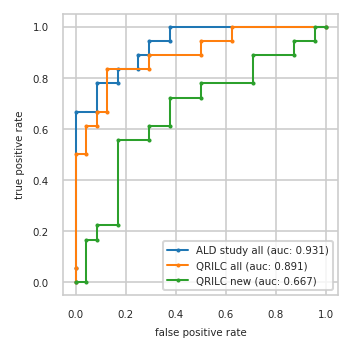

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.667     0.000 0.500     0.042 0.167
3          0.083 0.667     0.042 0.500     0.083 0.167
4          0.083 0.778     0.042 0.611     0.083 0.222
5          0.167 0.778     0.083 0.611     0.167 0.222
6          0.167 0.833     0.083 0.667     0.167 0.556
7          0.250 0.833     0.125 0.667     0.292 0.556
8          0.250 0.889     0.125 0.833     0.292 0.611
9          0.292 0.889     0.292 0.833     0.375 0.611
10         0.292 0.944     0.292 0.889     0.375 0.722
11         0.375 0.944     0.500 0.889     0.500 0.722
12         0.375 1.000     0.500 0.944     0.500 0.778
13         1.000 1.000     0.625 0.944     0.708 0.778
14           NaN   NaN     0.625 1.000     0.708 0.889
15           NaN   NaN     1.000 1.000     0.875 0.889
16           NaN   NaN       NaN   NaN     0.875 0.944
17           NaN   NaN       NaN   NaN     0.958 0.944
18           NaN   NaN       NaN   NaN     0.958 1.000
19           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P04075,Q9Y2T3;Q9Y2T3-3,P31321
1,Q9NRN5,P60709;P63261,None
2,P09486,P10636-2;P10636-6,None
3,K7ERG9;P00746,A0A0A0MRJ7;P12259,None
4,P14174,P14174,None
5,P10636-2;P10636-6,P61981,None
6,P61981,P04075,None
7,Q6EMK4,P00338;P00338-3,None
8,P14618,C9JF17;P05090,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


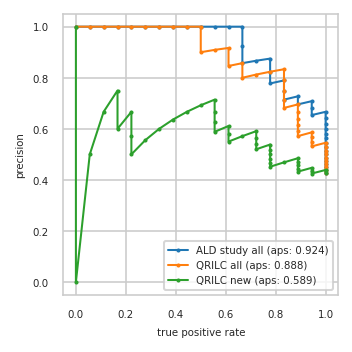

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.425 0.944
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.432 0.889
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.531 0.944     0.469 0.833
11         0.581 1.000     0.548 0.944     0.452 0.778
12         0.600 1.000     0.567 0.944     0.467 0.778
13         0.621 1.000     0.586 0.944     0.483 0.778
14         0.643 1.000     0.571 0.889     0.500 0.778
15         0.667 1.000     0.593 0.889     0.519 0.778
16         0.654 0.944     0.615 0.889     0.538 0.778
17         0.680 0.944     0.640 0.889     0.520 0.722
18         0.708 0.944     0.667 0.889     0.542 0.722
19         0.696 0.889     0.696 0.889     0.565 0.722
20         0.727 0.889     0.682 0.833     0.591 0.722
21         0.714 0.833     0.714 0.833     0.571 0.667
22         0.750 0.833     0.750 0.833     0.550 0.611
23         0.789 0.833     0.789 0.833     0.579 0.611
24         0.778 0.778     0.833 0.833     0.611 0.611
25         0.824 0.778     0.824 0.778     0.588 0.556
26         0.875 0.778     0.812 0.722     0.625 0.556
27         0.867 0.722     0.800 0.667     0.667 0.556
28         0.857 0.667     0.857 0.667     0.714 0.556
29         0.923 0.667     0.846 0.611     0.692 0.500
30         1.000 0.667     0.917 0.611     0.667 0.444
31         1.000 0.611     0.909 0.556     0.636 0.389
32         1.000 0.556     0.900 0.500     0.600 0.333
33         1.000 0.500     1.000 0.500     0.556 0.278
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


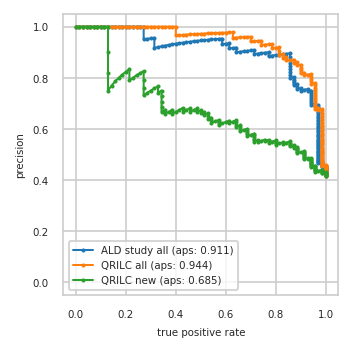

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


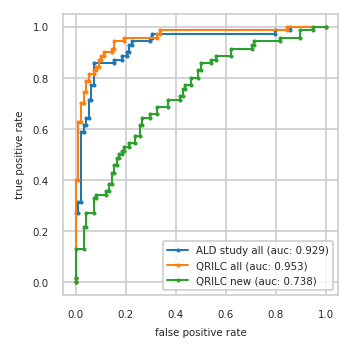

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}